# 하방 리스크 측정 : 반편차, 최대예상손실액(VaR), 조건부 최대예상손실액(CVaR)


이번 시간에는 하방 위험 측정하기 위한 몇 가지 도구들을 살펴볼 것입니다. 우리는 이미 낙폭을 계산하는 방법을 알고 있습니다. 여기서는 낙폭 이외에도 널리 사용되는 3가지 측정 지표들을 알아보고 이를 계산하는 코드를 작성하여 도구상자에 추가할 것입니다.

첫 번째 측정지표는 **반편차(Semi-Deviation)**로써 가장 단순한 측정치입니다. 이는 간단히 말해 음수인 수익률들의 변동성입니다.

코드 또한 매우 단순합니다.

```python
def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    is_negative = r < 0
    return r[is_negative].std(ddof=0)
```


In [1]:
import pandas as pd
import port_opt_toolkit as potk
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
hfi = potk.get_hfi_returns()

In [3]:
def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    is_negative = r < 0
    return r[is_negative].std(ddof=0)

In [4]:
potk.semideviation(hfi)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

In [5]:
hfi[hfi<0].std(ddof=0)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

In [6]:
potk.semideviation(hfi).sort_values()

Global Macro              0.006579
Merger Arbitrage          0.008875
Equity Market Neutral     0.009566
Funds Of Funds            0.012122
Relative Value            0.012244
CTA Global                0.012443
Long/Short Equity         0.014051
Distressed Securities     0.015185
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Convertible Arbitrage     0.019540
Short Selling             0.027283
Emerging Markets          0.028039
dtype: float64

In [7]:
ffme = potk.get_ffme_returns()
potk.semideviation(ffme)

SmallCap    0.051772
LargeCap    0.040245
dtype: float64

In [9]:
# This will not work
potk.semideviation([1,2,3,4])

TypeError: '<' not supported between instances of 'list' and 'int'

# VaR, CVaR

최대예상손실액(VaR, Value at Risk)를 계산하는 세 가지 방법을 살펴보겠습니다.

1. 역사적 VaR (Historical VaR)
2. 모수적 가우시안 VaR (Parametric Gaussian VaR)
3. 수정 VaR (Modified (Cornish-Fisher) VaR)

우선 역사적 VaR입니다. 특정 수준(예: 5%)에서 역사적 VaR를 계산하려면 수익률 집합을 순서대로 세워 그 중 하위 5%에 해당하는 값을 찾기만 하면 됩니다.

![역사적 VaR](./historical_var.jpg/)

다행히도, 넘파이는 `np.percentile`이라는 함수를 가지고 있고, 이 함수는 정확히 우리가 원하는 기능을 수행합니다.

아래의 코드 블록은 `port_opt_toolkit.py` 파일에 추가해보겠습니다.

```python

def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")        
```

In [14]:
import numpy as np
np.percentile(hfi, 5)

-0.0274

In [15]:
potk.var_historic(hfi, level=1)

Convertible Arbitrage     0.031776
CTA Global                0.049542
Distressed Securities     0.046654
Emerging Markets          0.088466
Equity Market Neutral     0.018000
Event Driven              0.048612
Fixed Income Arbitrage    0.041672
Global Macro              0.024316
Long/Short Equity         0.049558
Merger Arbitrage          0.025336
Relative Value            0.026660
Short Selling             0.113576
Funds Of Funds            0.039664
dtype: float64

VaR과 관련해서는 보고의 목적으로 부호를 바꾸는 것이 일반적이므로 손실, 즉 위험에 처한 금액을 나타내는 양수를 보고합니다.

# 조건부 최대예상손실액 (CVaR, Conditional VaR)

이제 VaR이 있으므로 CVaR은 매우 쉽습니다. CVaR는 단순히 VaR 값 밑으로 떨어진 숫자들의 평균입니다.

In [16]:
potk.cvar_historic(hfi, level=1).sort_values()

Global Macro              0.029333
Equity Market Neutral     0.036100
Merger Arbitrage          0.036233
Relative Value            0.052367
CTA Global                0.054767
Funds Of Funds            0.061133
Long/Short Equity         0.061867
Distressed Securities     0.070967
Event Driven              0.071267
Fixed Income Arbitrage    0.072467
Convertible Arbitrage     0.086100
Short Selling             0.123867
Emerging Markets          0.141167
dtype: float64

In [17]:
potk.cvar_historic(ffme)

SmallCap    0.162609
LargeCap    0.121277
dtype: float64

## 모수적 가우시안 VaR

모수적 가우시안 VaR에 대한 아이디어는 매우 간단합니다. 만약 수익률 집합이 정규 분포를 따르는 경우, 우리는 전체 수익률 집합의 절반은 평균 미만이고 나머지 절반은 평균 초과라는 것을 알고 있습니다.

또한 우리는 수익률의 약 2/3가 1 표준 편차 내에 있다는 것을 알고 있습니다. 이는 전체의 1/3이 평균에서 1 표준편차를 넘어선다는 것을 의미합니다. 정규 분포는 대칭이므로 데이터의 약 1/6(약 16%) 정도는 1 하방 표준 편차 아래에 있습니다. 따라서 평균과 표준편차를 알고 수익이 정규 분포를 따른다고 가정하면 16% VaR은 평균에서 표준편차 1을 뺀 값이 됩니다.

일반적으로 백분위수는 z-점수로 변환될 수 있습니다. 따라서 VaR 수준(예: 1% 또는 5%)을 z-점수로 변환할 수 있다면 해당 분위수에 위치한 수익률을 알 수 있습니다.

`scipy.stat.norm`에는 정확히 해당 기능을 수행하는 `ppf()` 함수가 포함되어 있습니다. 이는 0.05 또는 0.01과 같은 백분위수를 사용하여 정규 분포에 해당하는 z-점수를 제공합니다.

In [22]:
from scipy.stats import norm
norm.ppf(.5)

0.0

In [23]:
norm.ppf(.16)

-0.994457883209753

따라서 이 방법을 사용하여 VaR을 추정하기 위해 해야 할 일은 해당 백분위수 수준에 해당하는 z-점수를 찾은 다음 이를 표준 편차에 곱한 뒤 평균에 더하는 것입니다.

```python
from scipy.stats import norm
def var_gaussian(r, level=5):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    return -(r.mean() + z*r.std(ddof=0))
```

In [24]:
potk.var_gaussian(hfi)

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

In [25]:
potk.var_historic(hfi)

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

# 수정 VaR (Cornish-Fisher Modification)

코니쉬-피셔 수정 VaR은 우아하면서도 간단한 조정 방식입니다.

z-점수는 VaR을 찾기 위해 이동해야 하는 평균에서 얼마나 많은 표준 편차가 있는지 알려줍니다. 하지만 수익률이 정규 분포가 아닌 경우 z-점수는 부정확한 값을 제공할 수밖에 없습니다. 코니쉬-피셔의 기본 아이디어는 데이터의 왜도와 첨도를 관찰할 수 있으므로 z-점수를 그만큼 위아래로 조정하여 수정된 z-점수를 얻을 수 있다는 것입니다. 예를 들어, 직관적으로 다른 모든 조건이 동일할 때 왜도가 음수이면 z-점수를 더 낮추고 왜도가 양수이면 위로 올립니다.


$z_{cornishfisher}$라고 표기된 수정 z-s점수는 다음과 같은 공식을 따릅니다.

$$ z_{cornishfisher} = z +\frac{1}{6}(z^2-1)S + \frac{1}{24}(z^3-3z)(K-3)-\frac{1}{36}(2z^3-5z)S^2 $$

만약 `modified` 패러미터 값이 `True`라면 `z` 값을 조정하는 다음 코드가 실행됩니다.

```python
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
```

다시 작성된 `var_gaussian` 함수는 다음과 같습니다.

```python
from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
        
    return -(r.mean() + z*r.std(ddof=0))

```

이제 지금까지 구현한 여러 가지 방법들을 비교해보겠습니다.

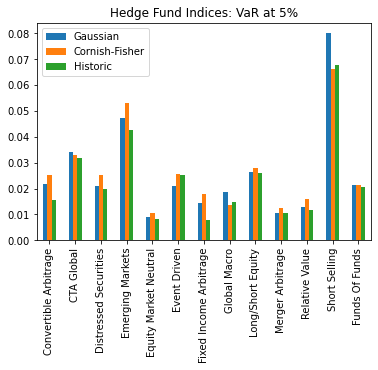

In [27]:
var_table = [potk.var_gaussian(hfi), 
             potk.var_gaussian(hfi, modified=True), 
             potk.var_historic(hfi)]
comparison = pd.concat(var_table, axis=1)
comparison.columns=['Gaussian', 'Cornish-Fisher', 'Historic']
comparison.plot.bar(title="Hedge Fund Indices: VaR at 5%")

어떤 경우에는 수정 VaR의 값이 가우스 분포를 가정한 VaR보다 더 낮습니다. 즉, 이는 정규 분포 가정에서 얻을 수 있는 것보다 더 작은 손실을 추정합니다. 이는 "공매도" 및 "글로벌 매크로"의 경우와 같이 관찰된 왜도가 양수인 경우 발생할 수 있습니다.

In [28]:
potk.skewness(hfi).sort_values(ascending=False)

Global Macro              0.982922
Short Selling             0.767975
CTA Global                0.173699
Funds Of Funds           -0.361783
Long/Short Equity        -0.390227
Emerging Markets         -1.167067
Distressed Securities    -1.300842
Merger Arbitrage         -1.320083
Event Driven             -1.409154
Relative Value           -1.815470
Equity Market Neutral    -2.124435
Convertible Arbitrage    -2.639592
Fixed Income Arbitrage   -3.940320
dtype: float64